In [1]:
import pandas as pd

In [2]:
df=pd.read_parquet(r'bccc-cpacket-cloud-ddos-2024-merged.parquet')

In [4]:
df.shape

(540494, 319)

In [2]:
data=pd.read_csv('final_data.csv')

In [9]:
data.shape

(540494, 39)

In [3]:
sampled_data=data.sample(frac=0.1,random_state=42)

In [11]:
data.columns

Index(['total_header_bytes', 'max_header_bytes', 'min_header_bytes',
       'mean_header_bytes', 'median_header_bytes', 'mode_header_bytes',
       'fwd_total_header_bytes', 'fwd_max_header_bytes',
       'fwd_min_header_bytes', 'fwd_mean_header_bytes',
       'fwd_median_header_bytes', 'fwd_mode_header_bytes',
       'fwd_init_win_bytes', 'bwd_init_win_bytes', 'packets_rate',
       'bwd_packets_rate', 'fwd_packets_rate', 'rst_flag_counts',
       'bwd_rst_flag_counts', 'psh_flag_percentage_in_total',
       'rst_flag_percentage_in_total', 'fwd_psh_flag_percentage_in_total',
       'fwd_syn_flag_percentage_in_fwd_packets',
       'bwd_psh_flag_percentage_in_bwd_packets',
       'bwd_rst_flag_percentage_in_bwd_packets', 'bwd_packets_IAT_mean',
       'bwd_packets_IAT_std', 'bwd_packets_IAT_max', 'bwd_packets_IAT_min',
       'bwd_packets_IAT_total', 'bwd_packets_IAT_median',
       'bwd_packets_IAT_mode', 'handshake_duration', 'handshake_state',
       'mean_bwd_packets_delta_time', 'm

In [4]:
X=sampled_data.drop('label',axis=1)

In [5]:
Y=sampled_data['label']

In [6]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [9]:
pipe=Pipeline([('scaler',StandardScaler()),('model',LogisticRegression())])
params={
        'model__C': [2], 
        'model__penalty': ['l1'],               
        'model__solver': ['saga'],       
        'model__max_iter': [10000],         
        'model__class_weight': [None],
        'model__multi_class': ['multinomial']
        }
grid=GridSearchCV(pipe,params,cv=5,n_jobs=-1,scoring='recall_weighted',verbose=1)
grid.fit(X_train,Y_train)
print(grid.best_params_)
print(grid.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\sahil\Desktop\DDOS PROJECT PART 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


{'model__C': 2, 'model__class_weight': None, 'model__max_iter': 10000, 'model__multi_class': 'multinomial', 'model__penalty': 'l1', 'model__solver': 'saga'}
0.9113993886218926


In [10]:
y_pred=grid.predict(X_test)
print(classification_report(Y_test,y_pred))
print(confusion_matrix(Y_test,y_pred))
print(accuracy_score(Y_test,y_pred))



              precision    recall  f1-score   support

      Attack       0.93      0.86      0.89      3334
      Benign       0.90      0.99      0.94      7039
  Suspicious       0.33      0.01      0.01       437

    accuracy                           0.91     10810
   macro avg       0.72      0.62      0.62     10810
weighted avg       0.89      0.91      0.89     10810

[[2860  470    4]
 [  92 6945    2]
 [ 111  323    3]]
0.9073080481036078


In [11]:
remaninng_data=data.drop(sampled_data.index)
y_unseen=remaninng_data['label']
x_unseen=remaninng_data.drop(columns=['label'])

In [12]:
y_unseen_pred=grid.predict(x_unseen)
print(classification_report(y_unseen,y_unseen_pred))
print(confusion_matrix(y_unseen,y_unseen_pred))
print(accuracy_score(y_unseen,y_unseen_pred))


              precision    recall  f1-score   support

      Attack       0.93      0.86      0.90    153564
      Benign       0.90      0.99      0.94    314126
  Suspicious       0.22      0.01      0.01     18755

    accuracy                           0.91    486445
   macro avg       0.69      0.62      0.62    486445
weighted avg       0.88      0.91      0.89    486445

[[132827  20584    153]
 [  4371 309564    191]
 [  4916  13741     98]]
0.9096382941545292


In [13]:
import matplotlib.pyplot as plt

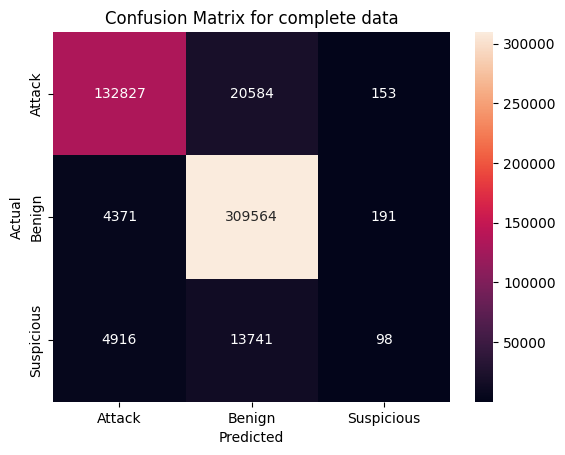

In [14]:
sns.heatmap(confusion_matrix(y_unseen,y_unseen_pred),annot=True,fmt='d',xticklabels=["Attack","Benign","Suspicious"],
            yticklabels=["Attack","Benign","Suspicious"])
plt.title("Confusion Matrix for complete data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
import joblib

In [17]:
artifact={
    'scaler':grid.best_estimator_.named_steps['scaler'],
    'model':grid.best_estimator_.named_steps['model'],
    'best_params':grid.best_params_,
    'best_score':grid.best_score_,
    'columns':X.columns
}

with open('LR_model_artifacts.pkl','wb') as f:
    joblib.dump(artifact,f)